In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import driver


In [3]:
foundation_breakdown = {
    'ecosystem': 100_000_000,
    'community_infra': 50_000_000,
    'fundraising': 77_000_000,
    'investments': 30_000_000,
    'research': 50_000_000,
}
# of these categories, ecosystem, community_infra, investments, and research are considered
# to be part of the community supply.
# so when we compute the percentage of the total supply for each emission type, we need to
# we take this into acocunt.  since the foundation is vested, 
# we assume all of these components vest at the same rate so we compute percentages.
foundation_to_community_pct = (
    foundation_breakdown['ecosystem'] + 
    foundation_breakdown['community_infra'] + 
    foundation_breakdown['investments'] + 
    foundation_breakdown['research']
) / sum(foundation_breakdown.values())
foundation_remaining_pct = 1 - foundation_to_community_pct


In [4]:
df_baseline = driver.sim2(
    ent_arrival_rate=100.0,  # average new entities per month
    ent_lifetime_months=24,  # entities depart after this many months
    subnet_lifetime_months=36,  # subnets depart after this many months
    initial_subnet_revenue=0,  # $100k initial revenue per subnet per month
    max_subnet_revenue=100000,  # $1M max revenue per subnet per month
    revenue_growth_months=48,  # months to reach max revenue
    revenue_burn_pct=0.5,  
    initial_token_price=0.30,  # $0.30 initial token price
    annual_price_growth_rate=0.0,  # 1% annual growth rate
    initial_target_staking_apy=0.08,  # 8% initial target staking APY
    final_target_staking_apy=0.04,  # 4% final target staking APY
    staking_apy_transition_months=48,  # months to transition from initial to final APY
    linear_start_emission=10_000_000,
    linear_end_emission=2_000_000,
    linear_total_emissions=225_000_000,
    dynamic_staking_fees=False,
)

df_price_decrease = driver.sim2(
    ent_arrival_rate=100.0,  # average new entities per month
    ent_lifetime_months=24,  # entities depart after this many months
    subnet_lifetime_months=36,  # subnets depart after this many months
    initial_subnet_revenue=0,  # $100k initial revenue per subnet per month
    max_subnet_revenue=100000,  # $1M max revenue per subnet per month
    revenue_growth_months=48,  # months to reach max revenue
    revenue_burn_pct=0.5,  
    initial_token_price=0.30,  # $0.30 initial token price
    annual_price_growth_rate=-0.05,  # 5% annual decrease
    initial_target_staking_apy=0.08,  # 8% initial target staking APY
    final_target_staking_apy=0.04,  # 4% final target staking APY
    staking_apy_transition_months=48,  # months to transition from initial to final APY
    linear_start_emission=10_000_000,
    linear_end_emission=2_000_000,
    linear_total_emissions=225_000_000,
    dynamic_staking_fees=False,
)

df_price_increase = driver.sim2(
    ent_arrival_rate=100.0,  # average new entities per month
    ent_lifetime_months=24,  # entities depart after this many months
    subnet_lifetime_months=36,  # subnets depart after this many months
    initial_subnet_revenue=0,  # $100k initial revenue per subnet per month
    max_subnet_revenue=100000,  # $1M max revenue per subnet per month
    revenue_growth_months=48,  # months to reach max revenue
    revenue_burn_pct=0.5,  
    initial_token_price=0.30,  # $0.30 initial token price
    annual_price_growth_rate=0.05,  # 1% annual growth rate
    initial_target_staking_apy=0.08,  # 8% initial target staking APY
    final_target_staking_apy=0.04,  # 4% final target staking APY
    staking_apy_transition_months=48,  # months to transition from initial to final APY
    linear_start_emission=10_000_000,
    linear_end_emission=2_000_000,
    linear_total_emissions=225_000_000,
    dynamic_staking_fees=False,
)


In [5]:
def plot_simulation_comparison(dataframes_dict, foundation_remaining_pct=0.5, foundation_to_community_pct=0.5):
    """
    Plot comparison of multiple simulation runs.
    
    Parameters:
    -----------
    dataframes_dict : dict
        Dictionary where keys are configuration labels (strings) and values are dataframes
        Example: {"Config A": df1, "Config B": df2, "Conservative": df3}
    foundation_remaining_pct : float
        Percentage of foundation tokens remaining (default 0.5)
    foundation_to_community_pct : float  
        Percentage of foundation tokens going to community (default 0.5)
    """
    
    # Create color map for different configurations
    cmap = plt.cm.get_cmap('tab10')
    colors = cmap.colors
    
    fig, ax = plt.subplots(figsize=(12, 11), nrows=3, ncols=3)
    
    # Iterate through each configuration
    for i, (config_label, df) in enumerate(dataframes_dict.items()):
        color = colors[i]
        
        # Plot 1: Community Portion of Supply
        axx = ax[0, 0]
        total_supply = df['team_vested'] + df['investor_vested'] + df['foundation_vested'] + df['cumulative_emissions']
        foundation_actual = df['foundation_vested'] * foundation_remaining_pct
        foundation_to_community = df['foundation_vested'] * foundation_to_community_pct
        community_pct = (df['cumulative_emissions'] + foundation_to_community) / total_supply
        axx.plot(df['month'], community_pct*100, color=color, label=config_label)
        
        # Plot 2: Circulating Supply
        axx = ax[0, 1]
        axx.plot(df['month'], df['circulating_supply']/1e6, color=color, label=config_label)
        
        # Plot 3: Locked Supply
        axx = ax[0, 2]
        axx.plot(df['month'], df['total_locked_supply']/1e6, color=color, label=config_label)
        
        # Plot 4: Locked/Circulating Percentage
        axx = ax[1, 0]
        axx.plot(df['month'], df['total_locked_supply']/df['circulating_supply']*100, color=color, label=config_label)
        
        # Plot 5: Inflation Rate
        axx = ax[1, 1]
        axx.plot(df['month'], df['total_emissions']/df['circulating_supply'].shift(1)*100, color=color, label=config_label)
        
        # Plot 6: Burn/Emissions Percentage
        axx = ax[1, 2]
        axx.plot(df['month'], df['cumulative_burn']/df['cumulative_emissions']*100, color=color, label=config_label)
        
        # Plot 7: Subnet Reward Emissions
        axx = ax[2, 0]
        axx.plot(df['month'], df['base_emissions']/1e6, color=color, label=config_label)
        
        # Plot 8: Staking Emissions
        axx = ax[2, 1]
        axx.plot(df['month'], df['additional_staking_emissions']/1e6, color=color, label=config_label)
        
        # Plot 9: Average Subnet Reward per Month
        axx = ax[2, 2]
        axx.plot(df['month'], (df['base_emissions']/1e6)/df['active_subnets'], color=color, label=config_label)
    
    # Set up all the plot formatting
    # Plot 1
    axx = ax[0, 0]
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_ylabel('%')
    axx.set_title('Community Portion of Supply')
    # axx.legend()
    
    # Plot 2
    axx = ax[0, 1]
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_title('Circulating Supply')
    axx.legend()
    
    # Plot 3
    axx = ax[0, 2]
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_title('Locked Supply')
    # axx.legend()
    
    # Plot 4
    axx = ax[1, 0]
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_ylabel('%')
    axx.set_title('Locked/Circulating Pct.')
    # axx.legend()
    
    # Plot 5
    axx = ax[1, 1]
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_ylabel('%')
    axx.set_title('Monthly Inflation Rate')
    axx.legend()
    
    # Plot 6
    axx = ax[1, 2]
    axx.axhline(y=100, color='grey', linestyle='--', linewidth=0.5)
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_ylabel('%')
    axx.set_title('Burn/Emissions Pct.')
    axx.set_ylim(0, 150)
    # axx.legend()
    
    # Plot 7
    axx = ax[2, 0]
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_ylabel('M-ROBO')
    axx.set_title('Subnet Reward Emissions')
    # axx.legend()
    
    # Plot 8
    axx = ax[2, 1]
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_ylabel('M-ROBO')
    axx.set_title('Staking Emissions')
    axx.legend()
    
    # Plot 9
    axx = ax[2, 2]
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_title('Avg. Subnet Reward / Mo')
    axx.set_xlabel('Month')
    axx.set_ylabel('M-ROBO')
    # axx.legend()
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1354586/629394395.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


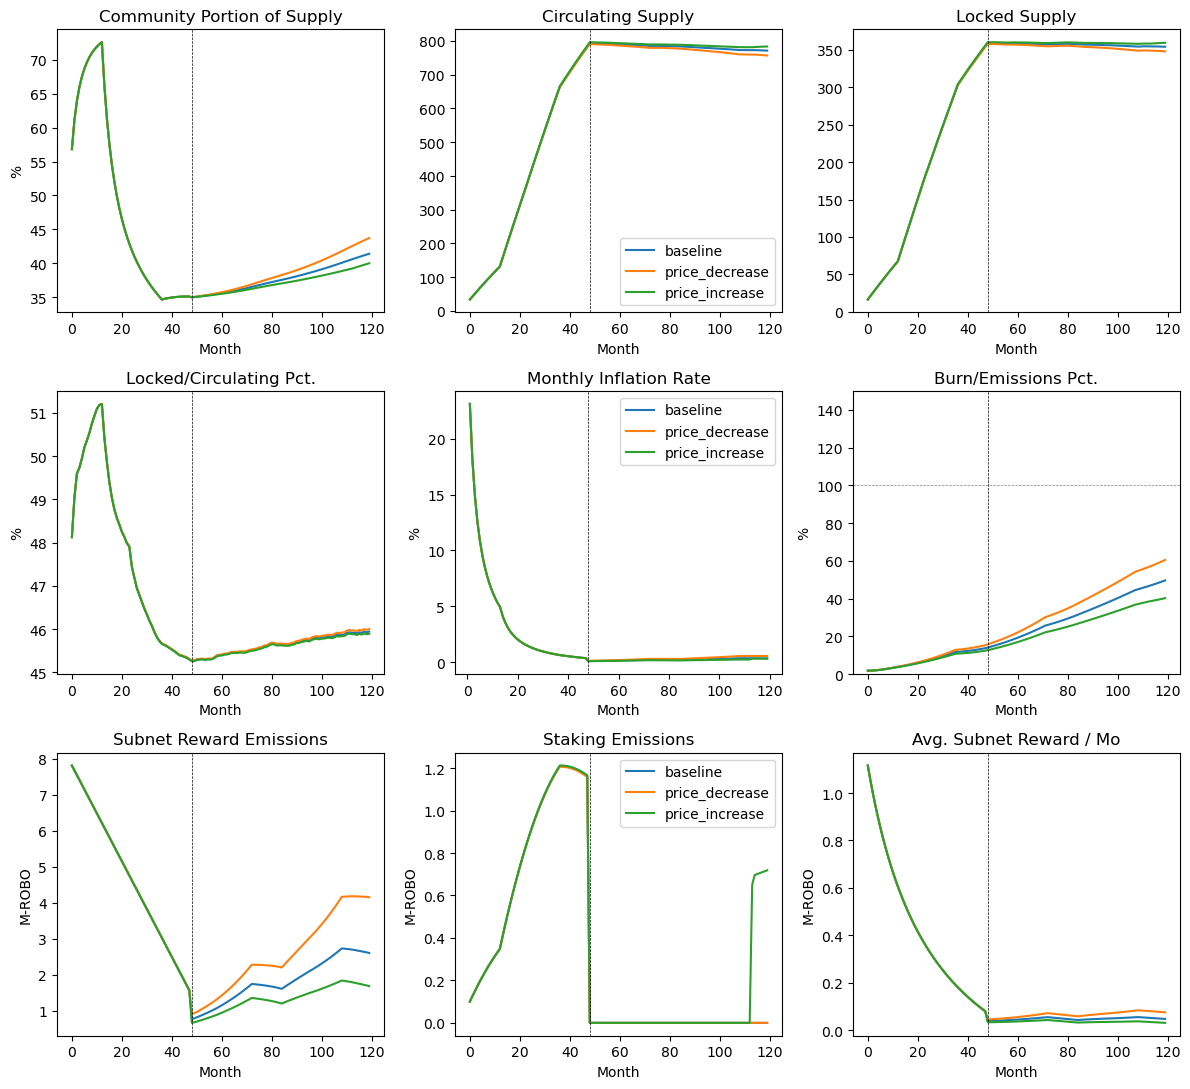

In [6]:
plot_simulation_comparison(
    {
        'baseline': df_baseline,
        'price_decrease': df_price_decrease,
        'price_increase': df_price_increase,
    }
)